## CS536: Computing Solutions
#### Done by: Vedant Choudhary, vc389

### Linear Regression
Consider data generated in the following way:

- $X_1$ through $X_{10}$ and $X_{16}$ through $X_{20}$ are i.i.d. standard normals
- $X_{11} = X_1 + X_2 + N (\mu=0, \sigma^2=0.1)$
- $X_{12} = X_3 + X_4 + N (\mu=0, \sigma^2=0.1)$
- $X_{13} = X_4 + X_5 + N (\mu=0, \sigma^2=0.1)$
- $X_{14} = 0.1X_7 + N (\mu=0, \sigma^2=0.1)$
- $X_{15} = 2X_2 - 10 +N (\mu=0, \sigma^2=0.1)$

The values $Y$ are generated according to the following linear model:
$$ Y = 10 + \sum_{i=1}^10{(0.6)^iX_i} $$

Note, the variables $X_{11}$ through $X_{20}$ are technically irrelevant

In [129]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
from tqdm import tqdm
import seaborn as sns
from copy import copy

%matplotlib inline

#### 1. Generate a data set of size m = 1000. Solve the naive least squares regression model for the weights and bias that minimize the training error - how do they compare to the true weights and biases? What did your model conclude as the most significant and least significant features - was it able to prune anything? Simulate a large test set of data and estimate the ‘true’ error of your solved model.

In [130]:
# Creating X (feature) vectors for the data
def create_data(m):
    X_1_10 = np.random.normal(0, 1, (m,11))
    X_11 = np.asarray([X_1_10[i][1] + X_1_10[i][2] + np.random.normal(loc=0, scale=(0.1)**(0.5)) for i in range(m)]).reshape((-1,1))
    X_12 = np.asarray([X_1_10[i][3] + X_1_10[i][4] + np.random.normal(loc=0, scale=(0.1)**(0.5)) for i in range(m)]).reshape((-1,1))
    X_13 = np.asarray([X_1_10[i][4] + X_1_10[i][5] + np.random.normal(loc=0, scale=(0.1)**(0.5)) for i in range(m)]).reshape((-1,1))
    X_14 = np.asarray([0.1*X_1_10[i][7] + np.random.normal(loc=0, scale=(0.1)**(0.5)) for i in range(m)]).reshape((-1,1))
    X_15 = np.asarray([2*X_1_10[i][2] - 10 + np.random.normal(loc=0, scale=(0.1)**(0.5)) for i in range(m)]).reshape((-1,1))
    X_16_20 = np.random.normal(0, 1, (m, 5))

    return np.concatenate((X_1_10, X_11, X_12, X_13, X_14, X_15, X_16_20), axis=1)

# Creating target column for the data
def create_y(X, m):
    y = []
    for i in range(m):
        temp = 10
        for j in range(1, 11):
            temp += ((0.6)**j)*X[i][j] 
        temp += np.random.normal(loc=0, scale=(0.1)**(0.5))
        y.append(temp)
        
    return np.asarray(y)

# Combining all the sub data points into a dataframe
def create_dataset(m):
    X = create_data(m)
    y = create_y(X, m).reshape((m,1))
#     print(X)
    # Training data is an appended version of X and y arrays
    data = pd.DataFrame(np.append(X, y, axis=1), columns=["X" + str(i) for i in range(21)]+['Y'])
    data['X0'] = 1
    return data

In [131]:
m = 1000

train_data = create_dataset(m)
train_data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,Y
0,1,-0.223183,-0.341442,-0.212054,0.340895,0.015303,-0.480602,1.485098,-0.162625,-1.379016,...,0.310831,0.198638,-0.619940,-10.071366,1.701040,0.219483,1.156263,-1.632300,0.559197,9.464393
1,1,-0.109276,-0.438618,-1.602431,0.034427,-1.559726,-1.489474,0.170016,-0.563177,0.112229,...,-1.864100,-1.415195,0.175783,-11.354063,0.905196,-0.741765,-0.422968,0.360285,0.255855,9.235210
2,1,1.230964,0.449564,1.487874,0.119978,-0.827904,-0.612675,2.488065,1.400398,0.042239,...,1.373967,-0.466684,0.301630,-8.780375,-1.357708,-1.380576,-0.953780,0.487521,1.242873,11.395728
3,1,-0.248755,0.632116,0.866264,-0.958149,-0.044653,0.189362,0.122920,-0.550167,0.138404,...,0.188137,-1.331275,0.171274,-9.020082,-0.317885,1.466300,-0.134466,1.690367,0.271977,10.199439
4,1,-0.349616,-1.028338,0.051943,1.045018,1.373768,1.713602,0.122428,1.196012,-0.618642,...,1.462870,2.746490,0.449546,-12.674276,1.427981,-1.460374,1.055929,2.863542,-0.225577,9.380523


In [132]:
class LinearRegression():
    def __init__(self):
        pass
    
    def thresh(self, support, lmbda):
        if support > 0.0 and lmbda < abs(support):
            return (support - lmbda)
        elif support < 0.0 and lmbda < abs(support):
            return (support + lmbda)
        else:
            return 0.0
        
    def naive_regression(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(shape=(n_features,1))
        self.w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
        return self.w
    
    def ridge_regression(self, X, y, lmbda):
        n_samples, n_features = X.shape
        self.w = np.zeros(shape=(n_features,1))
        self.w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + lmbda*np.identity(n_features)), X.T), y)
        return self.w
    
    def lasso_regression(self, X, y, lmbda, iterations):
        n_samples, n_features = X.shape
        self.w = np.zeros(shape=(n_features,1))
        
#         Since bias is basically mean of original - predictions
        self.w[0] = np.sum(y - np.dot(X[:, 1:], self.w[1:]))/n_samples
        
        for i in range(iterations):
            for j in range(1, n_features):
                copy_w = self.w.copy()
                copy_w[j] = 0.0
                residue = y - np.dot(X, copy_w)
                a1 = np.dot(X[:, j], residue)
                a2 = lmbda*n_samples
                
                self.w[j] = self.thresh(a1, a2)/(X[:, j]**2).sum()           
        
        return self.w
        
    def predict(self, X, w):
        return np.dot(X, w)
    
    def error_calculation(self, X, y, w):
        h_x = self.predict(X, w)
        error = 0
        for i in range(len(y)):
            error += (y[i] - h_x[i])**2

        error /= len(y)
        return error

In [133]:
def plot_comparison(actual, predicted, features):
    plt.figure(figsize=(8,6))
    data_actual = pd.DataFrame(pd.Series(actual), columns=['weight'])
    data_actual['type'] = pd.Series(['actual']*len(actual))
    data_actual['feature'] = pd.Series(list(range(features)))
    data_actual = data_actual.iloc[1:]
    
    data_pred = pd.DataFrame(pd.Series(predicted), columns=['weight'])
    data_pred['type'] = pd.Series(['pred']*len(predicted))
    data_pred['feature'] = pd.Series(list(range(features)))
    data_pred = data_pred.iloc[1:]
    
    data = pd.concat([data_actual, data_pred])

    sns.barplot(x="feature", y="weight", hue="type", data=data)

Error:  0.09788375096908075
Trained Bias:  [10.39936254]


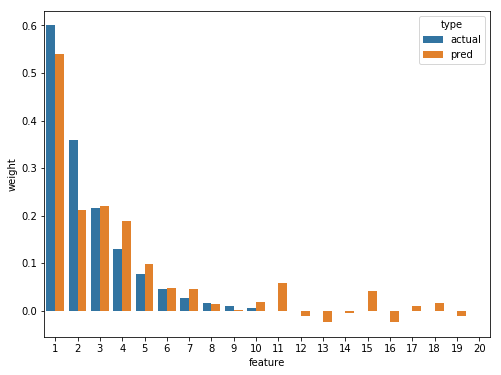

In [134]:
lin_reg = LinearRegression()
X = np.asarray(train_data.iloc[:,:-1])
y = np.asarray(train_data.iloc[:,-1:])

w_actual = [10]
for i in range(1, 21):
    if i <= 10:
        w_actual.append((0.6)**i)
    else:
        w_actual.append(0)
        
w_trained = lin_reg.naive_regression(X, y)
features = X.shape[1]

# print(w_trained)
plot_comparison(w_actual, w_trained.flatten(), features)
print("Error: ", float(lin_reg.error_calculation(X, y, w_trained)))
print("Trained Bias: ", w_trained[0])

- After training the model on naive least squares regression and comparing the predicted weights and bias with true ones, we see that the predicted weights are in line with the true weights but there is some weight associated to irrelevant variables too. 
- The bias value has been printed instead of charting, to maintain the y-axis range. Trained bias is also similar to actual bias
- This model regards X1 as the most significant and X16 as least significant feature
- This naive model has no mechanism to perform pruning of features.

In [135]:
def estimated_error(w):
    estimated_error = 0
    for i in (range(10)):
        data = create_dataset(10000)
        X = np.asarray(data.iloc[:,:-1])
        y = np.asarray(data.iloc[:,-1:])
        estimated_error += lin_reg.error_calculation(X, y, w)
        
    return float(estimated_error/10)
    
estimated_err = estimated_error(w_trained)
print("True error: ", estimated_err)

True error:  0.10331549595964984


#### 2. Write a program to take a data set of size m and a parameter λ, and solve for the ridge regression model for that data. Write another program to take the solved model and estimate the true error by evaluating that model on a large test data set. For data sets of size m = 1000, plot estimated true error of the ridge regression model as a function of λ. What is the optimal λ to minimize testing error? What are the weights and biases ridge regression gives at this λ, and how do they compare to the true weights? What did your model conclude as the most significant and least significant features - was it able to prune anything? How does the optimal ridge regression model compare to the naive least squares model?

In [136]:
lmbda = 0.01
w_lambda = lin_reg.ridge_regression(X, y, lmbda)
    
estimated_err = estimated_error(w_lambda)
estimated_err

0.10304444212238675

0.0	0.03	0.06	0.09	0.12	0.15	0.18	0.21	0.24	0.27	0.3	0.33	0.36	0.39	0.42	0.45	0.48	0.51	0.54	0.57	0.6	0.63	0.66	0.69	0.72	0.75	0.78	0.81	0.84	0.87	0.9	0.93	0.96	0.99	

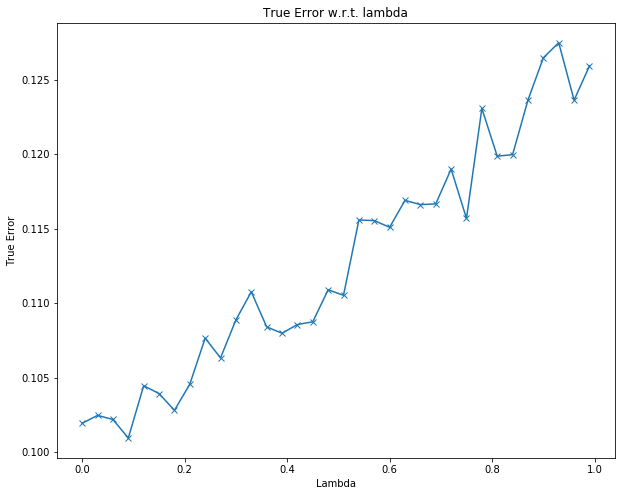

In [138]:
def varying_lambda(m):
    lmbda = np.arange(0, 1, 0.03)
    estimated_error_list = []
    
    for i in lmbda:
        print(round(i, 2), end='\t')
        error = 0
        data = create_dataset(m)
        X = np.asarray(data.iloc[:,:-1])
        y = np.asarray(data.iloc[:,-1:])
        lin_reg = LinearRegression()
        w = lin_reg.ridge_regression(X, y, i)
        estimated_error_list.append(estimated_error(w))
    
    plt.figure(figsize=(10,8))
    plt.plot(lmbda, estimated_error_list, marker='x')
    plt.title("True Error w.r.t. lambda")
    plt.xlabel("Lambda")
    plt.ylabel("True Error")
    plt.show()

varying_lambda(1000)

As can be seen from the plot, as the value of lambda is increased, the true error of the ridge regression model also increases. For this example, we can see that an optimal lambda value is in the range [0.08, 0.1)

Error:  0.09847570035843019


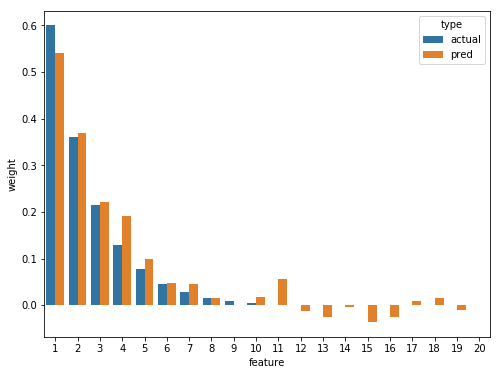

In [139]:
w_lambda = lin_reg.ridge_regression(X, y, 0.08)
    
estimated_err = estimated_error(w_lambda)

plot_comparison(w_actual, w_lambda.flatten(), features)
print("Error: ", float(lin_reg.error_calculation(X, y, w_lambda)))

In [141]:
print("Weights (Bias at zero index): \n", w_lambda)

Weights (Bias at zero index): 
 [[ 9.62390292e+00]
 [ 5.41622444e-01]
 [ 3.69909690e-01]
 [ 2.21950260e-01]
 [ 1.92036956e-01]
 [ 9.95898328e-02]
 [ 4.70618432e-02]
 [ 4.50264230e-02]
 [ 1.52463488e-02]
 [ 1.08180493e-03]
 [ 1.90302482e-02]
 [ 5.62007319e-02]
 [-1.24200773e-02]
 [-2.38501530e-02]
 [-2.54662157e-03]
 [-3.54780096e-02]
 [-2.44296395e-02]
 [ 9.59621778e-03]
 [ 1.67828267e-02]
 [-1.04992299e-02]
 [ 1.69407339e-03]]


- The above plots convey that on using the optimal value of lambda from ridge regression (0.08 in this case), we get weights and bias very similar to the actual weights and bias
- The ridge regression model considers X1 to be most significant, while X15 to be the least
- I do not believe that ridge was able to prune any variables since they have some weights associated to the features

#### 3. Write a program to take a data set of size m and a parameter λ, and solve for the Lasso regression model for that data. For a data set of size m = 1000, show that as λ increases, features are effectively eliminated from the model until all weights are set to zero.

In [144]:
lmbda = np.arange(0, 1.0, 0.01)
weights = []
lin_reg = LinearRegression()

for l in lmbda:
    print(round(l,2), end='\t')
    weight = lin_reg.lasso_regression(X, y, l, 100)
    weights.append(weight.flatten())
    
weights_lasso = np.stack(weights).T
weights_lasso[1:].shape

0.0	0.01	0.02	0.03	0.04	0.05	0.06	0.07	0.08	0.09	0.1	0.11	0.12	0.13	0.14	0.15	0.16	0.17	0.18	0.19	0.2	0.21	0.22	0.23	0.24	0.25	0.26	0.27	0.28	0.29	0.3	0.31	0.32	0.33	0.34	0.35	0.36	0.37	0.38	0.39	0.4	0.41	0.42	0.43	0.44	0.45	0.46	0.47	0.48	0.49	0.5	0.51	0.52	0.53	0.54	0.55	0.56	0.57	0.58	0.59	0.6	0.61	0.62	0.63	0.64	0.65	0.66	0.67	0.68	0.69	0.7	0.71	0.72	0.73	0.74	0.75	0.76	0.77	0.78	0.79	0.8	0.81	0.82	0.83	0.84	0.85	0.86	0.87	0.88	0.89	0.9	0.91	0.92	0.93	0.94	0.95	0.96	0.97	0.98	0.99	

(20, 100)

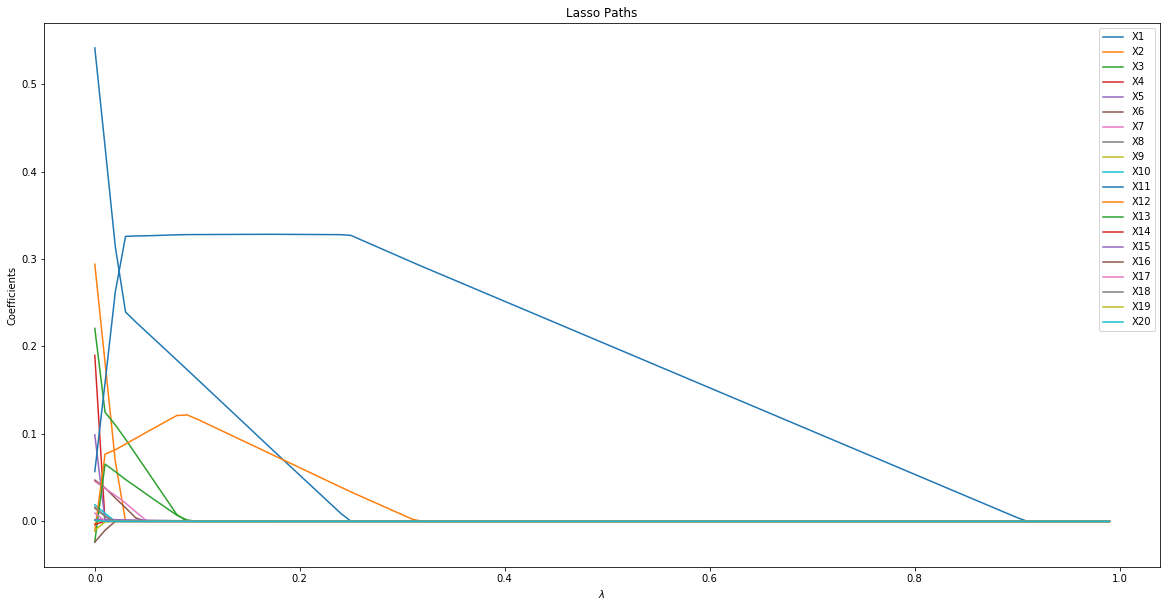

In [149]:
n,_ = weights_lasso[1:].shape
plt.figure(figsize = (20,10))

for i in range(n):
    plt.plot(lmbda, weights_lasso[1:][i], label = train_data.columns[1:][i])

# plt.xscale('log')
plt.xlabel('$\\lambda$')
plt.ylabel('Coefficients')
plt.title('Lasso Paths')
plt.legend()
plt.axis('tight')
plt.show()

- This plot shows that as the value of lambda is increased, it starts pruning more and more variables/features of the dataset.
- So, all feature weights tend towards 0 at some value of lambda.

#### 4. For data sets of size m = 1000, plot estimated true error of the lasso regression model as a function of λ. What is the optimal λ to minimize testing error? What are the weights and biases lasso regression gives at this λ, and how do they compare to the true weights? What did your model conclude as the most significant and least signficiant features - was it able to prune anything? How does the optimal regression model compare tot he naive least squares model?

0.0	0.01	0.02	0.03	0.04	0.05	0.06	0.07	0.08	0.09	0.1	0.11	0.12	0.13	0.14	0.15	0.16	0.17	0.18	0.19	0.2	0.21	0.22	0.23	0.24	0.25	0.26	0.27	0.28	0.29	0.3	0.31	0.32	0.33	0.34	0.35	0.36	0.37	0.38	0.39	0.4	0.41	0.42	0.43	0.44	0.45	0.46	0.47	0.48	0.49	0.5	0.51	0.52	0.53	0.54	0.55	0.56	0.57	0.58	0.59	0.6	0.61	0.62	0.63	0.64	0.65	0.66	0.67	0.68	0.69	0.7	0.71	0.72	0.73	0.74	0.75	0.76	0.77	0.78	0.79	0.8	0.81	0.82	0.83	0.84	0.85	0.86	0.87	0.88	0.89	0.9	0.91	0.92	0.93	0.94	0.95	0.96	0.97	0.98	0.99	

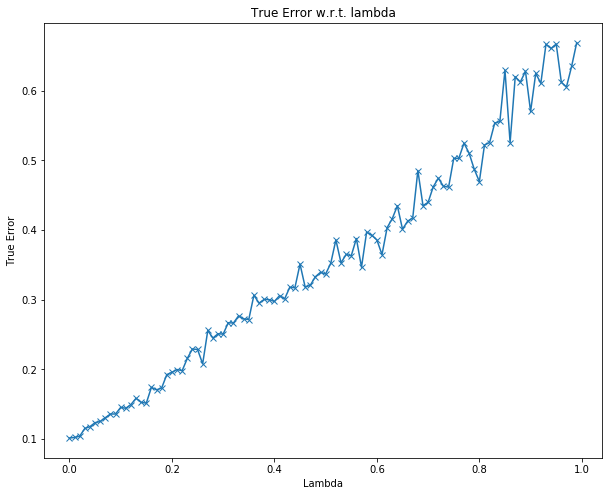

In [150]:
def varying_lambda_lasso(m):
    lmbda = np.arange(0, 1, 0.01)
    estimated_error_list = []
    
    for i in lmbda:
        print(round(i,2), end="\t")
        error = 0
        data = create_dataset(m)
        X = np.asarray(data.iloc[:,:-1])
        y = np.asarray(data.iloc[:,-1:])
        lin_reg = LinearRegression()
        w = lin_reg.lasso_regression(X, y, i, 100)
        estimated_error_list.append(estimated_error(w))
    
    plt.figure(figsize=(10,8))
    plt.plot(lmbda, estimated_error_list, marker='x')
    plt.title("True Error w.r.t. lambda")
    plt.xlabel("Lambda")
    plt.ylabel("True Error")
    plt.show()

varying_lambda_lasso(1000)

The minimum is occuring in the range [0, 0.01], so let us calculate the optimal lasso regression bias and weights by having a value of lambda between the range.

Error:  0.09813363129991692


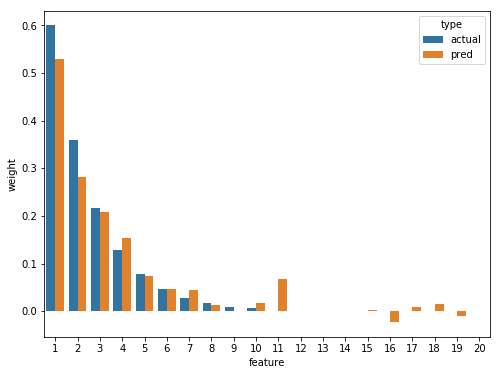

In [151]:
optimal_weight = lin_reg.lasso_regression(X, y, 0.001, 1000)
plot_comparison(w_actual, optimal_weight.flatten(), features)
print("Error: ", float(lin_reg.error_calculation(X, y, optimal_weight)))

- Optimal Lasso weights are almost equal to actual weights. However, the model makes feature X9 insignificant.
- The model is mostly recognizing the variables from X11 to X20 to be insignificant, with having X12, X13, X14 as 0
- The model prunes some of the insignificant weights
- The model is working almost like the naive regression model

#### 5. Consider using lasso as a means for feature selection: on a data set of size m = 1000, run lasso regression with the optimal regularization constant from the previous problems, and identify the set of relevant features; then run ridge regression to fit a model to only those features. How can you determine a good ridge regression regularization constant to use here? How does the resulting lasso-ridge combination model compare to the naive least squares model? What features does it conclude are significant or relatively insignificant? How do the testing errors of these two models compare?

Error:  0.09512039687787044


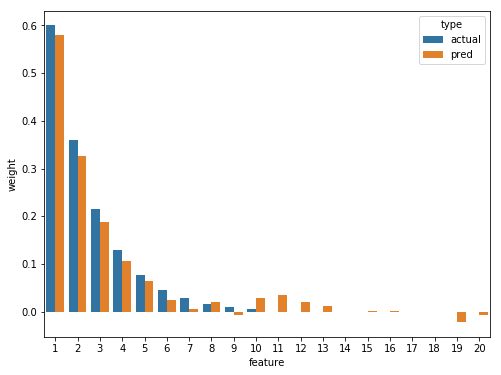

In [152]:
new_data = create_dataset(1000)
linreg = LinearRegression()
X = np.asarray(new_data.iloc[:,:-1])
y = np.asarray(new_data.iloc[:,-1:])
new_weight = linreg.lasso_regression(X, y, 0.001, 100)

plot_comparison(w_actual, new_weight.flatten(), features)
print("Error: ", float(lin_reg.error_calculation(X, y, new_weight)))

In [153]:
feature_weights = dict(zip(*(new_data.drop(['Y'], 1).columns, new_weight)))
feature_weights

{'X0': array([10.01100229]),
 'X1': array([0.57957789]),
 'X2': array([0.32560637]),
 'X3': array([0.18779209]),
 'X4': array([0.10552412]),
 'X5': array([0.06563217]),
 'X6': array([0.02508582]),
 'X7': array([0.00576315]),
 'X8': array([0.02015043]),
 'X9': array([-0.00747178]),
 'X10': array([0.02843073]),
 'X11': array([0.03459142]),
 'X12': array([0.02009376]),
 'X13': array([0.01177798]),
 'X14': array([0.]),
 'X15': array([0.00126216]),
 'X16': array([0.0018779]),
 'X17': array([-0.00134243]),
 'X18': array([0.]),
 'X19': array([-0.02123867]),
 'X20': array([-0.00595181])}

The relevant features are features with positive weights. So, according to the above output, the relevant features are:
[X1, ...X8, X10,..., X13, X15, X16]

Even though the weights for insignificant values is low, we'll be considering them since they are positive

In [154]:
relevant_features = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X10", "X11", "X12", "X13", "X15", "X16", "Y"]
rel = [a[1:] for a in relevant_features[:-1]]
trim_data = new_data[relevant_features]
trim_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X10,X11,X12,X13,X15,X16,Y
0,-0.759937,-1.865792,-1.535536,0.781853,-1.622637,0.660121,-0.860733,-1.183100,-0.185960,-2.590359,-0.676306,-0.546848,-13.625341,-1.892044,8.507691
1,0.791694,1.862048,-0.367749,-0.028321,-0.175219,1.209357,-0.500735,0.675537,1.135193,2.458988,-0.448314,-0.374797,-6.664710,0.509057,11.656306
2,0.371409,-0.885041,0.790290,-0.816246,-0.126864,-0.056052,-0.021161,-0.110605,-1.033657,-0.884169,-0.515417,-0.964315,-11.768042,-0.880033,9.346974
3,-1.449173,0.645438,-0.483889,0.415232,0.854699,0.521937,-0.250297,-1.589247,1.015546,-0.857674,-0.120994,1.788627,-8.607964,0.845954,9.151327
4,0.865251,1.773843,0.287900,1.716583,0.553109,-1.095341,0.678118,0.268131,-0.545859,2.818611,2.414920,2.498909,-6.237809,0.832851,11.273237


In [155]:
X_trim = np.asarray(trim_data.iloc[:,:-1])
y_trim = np.asarray(trim_data.iloc[:,-1:])

trim_actual_weights = []

for i in range(1, 21):
    if str(i) in rel:
        trim_actual_weights.append(w_actual[i])
    else:
        trim_actual_weights.append(0)

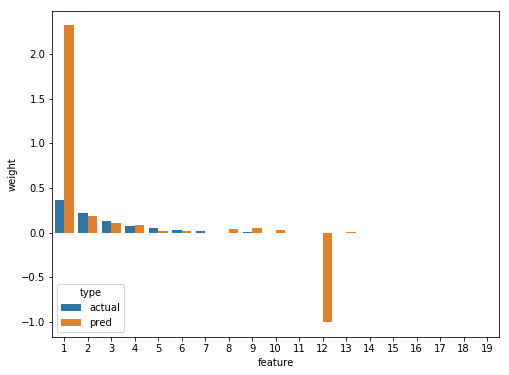

In [156]:
new_ridge = LinearRegression()
w_lambda_2 = new_ridge.ridge_regression(X_trim, y_trim, 0.001)

plot_comparison(trim_actual_weights, w_lambda_2.flatten(), features)

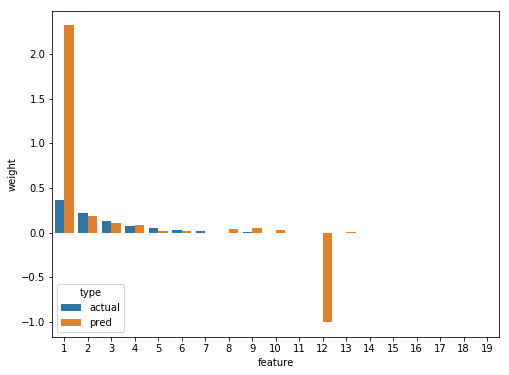

In [157]:
w_lambda_2 = new_ridge.ridge_regression(X_trim, y_trim, 0.01)

plot_comparison(trim_actual_weights, w_lambda_2.flatten(), features)

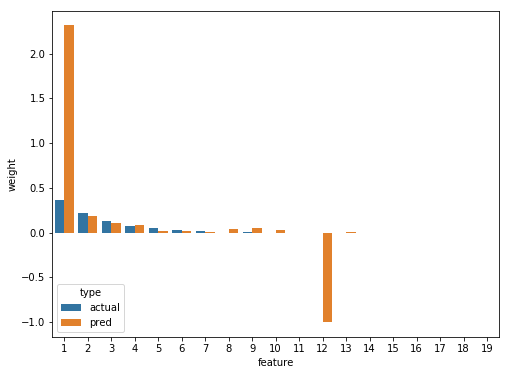

In [161]:
w_lambda_2 = new_ridge.ridge_regression(X_trim, y_trim, 0.1)

plot_comparison(trim_actual_weights, w_lambda_2.flatten(), features)

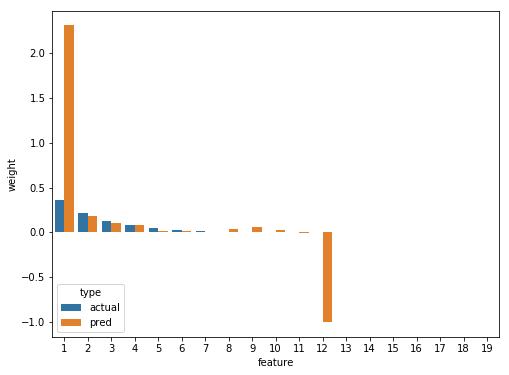

In [162]:
w_lambda_2 = new_ridge.ridge_regression(X_trim, y_trim, 0.3)

plot_comparison(trim_actual_weights, w_lambda_2.flatten(), features)

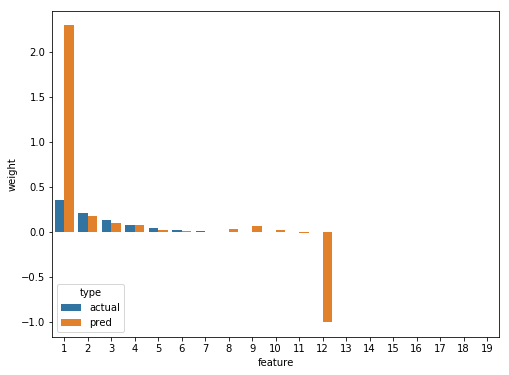

In [163]:
w_lambda_2 = new_ridge.ridge_regression(X_trim, y_trim, 0.7)

plot_comparison(trim_actual_weights, w_lambda_2.flatten(), features)

- We see that as the value of $\lambda$ increases, the insignifcant features are eliminated. Let us try to calculate true error
- Features after X12 have been considered as insignificant by this model. It has somehow also made X7 as insignificant
- For lambda close to 0.01, least true error is there in the model. 

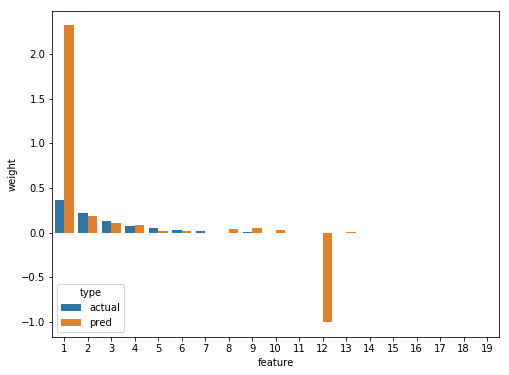

In [175]:
w_lambda_2 = new_ridge.ridge_regression(X_trim, y_trim, 0.01)

plot_comparison(trim_actual_weights, w_lambda_2.flatten(), features)

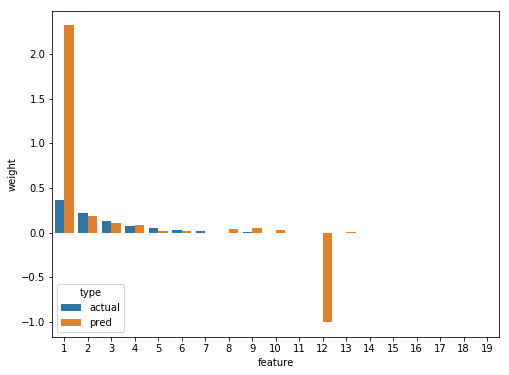

In [173]:
w_lambda_2 = new_ridge.naive_regression(X_trim, y_trim)
plot_comparison(trim_actual_weights, w_lambda_2.flatten(), features)

- We observe that the weights given by the models are almost the same.

### SVM

#### 1. Implement a barrier-method dual SVM solver. How can you (easily!) generate an initial feasible α solution away from the boundaries of the constraint region? How can you ensure that you do not step outside the constraint region in any update step? How do you choose your $\epsilon_t$? Be sure to return all $\alpha_i$ including $\alpha_i$ in the final answer.

Using Damped Newton's method for recentering in the Barrier method to solve dual SVM:

$$minimize \phi_t(x) = t(0.5x^TQx + p^Tx) + B(b-Ax)$$

where B is the logarithmic barrier defined as:
$$B(x) = - \sum_i{log(x_i)}$$

The steps followed below have been referred from this article https://github.com/lenassero/linear-svm

In [120]:
class SVM():
    def __init__(self, tau=1, t_0=1, tol=0.0001, mu=15, sol="Dual", kernel=None, poly_d=2):
        self.tau = tau
        self.t_0 = t_0
        self.tol = tol
        self.mu = mu
        self.kernel = kernel
        self.poly_d = poly_d
        self.sol = sol
        
    def damp_newt_step(self, x, objective_func, grad, hess):
        g = grad(x)
        h = hess(x)
        h_inverse = np.linalg.inv(h)
        lmbda = np.sqrt((g.T.dot(h_inverse.dot(g))))
        x_new = x - (1/(1+lmbda))*h_inverse.dot(g)
        gap = 0.5*lmbda**2
        return x_new, gap

    def damp_newt_method(self, x, objective_func, grad, hess):
        x, gap = self.damp_newt_step(x, objective_func, grad, hess)
        x_histogram = [x]
        if self.tol < (3-(5**0.5))/2:
            while gap > self.tol:
                x, gap = self.damp_newt_step(x, objective_func, grad, hess)
            x_histogram.append(x)
            x_star = x
        else:
            raise ValueError("tol should be less than the condition value")
        return x_star, x_histogram
    
    def transform_dual_svm(self, tau, X, y):
        n_obs = X.shape[1]
        if self.kernel == "Polynomial":
            K = (np.identity(n=n_obs) + X.T.dot(X)) ** self.poly_d
            Q = (y*y)*K
        else:
            Q = (X*y).T.dot(X*y)
        p = -np.ones(n_obs)
        A = np.zeros((2 * n_obs, n_obs))
        A[:n_obs, :] = np.identity(n_obs)
        A[n_obs:, :] = -np.identity(n_obs)
        b = np.zeros(2 * n_obs)
        b[:n_obs] = 1 / (tau * n_obs)
        
        return Q, p, A, b
    
    def transform_primal_svm(self, tau, X, y):
        d = X.shape[0]
        d_ = d - 1
        n = X.shape[1]
        Q = np.zeros((d+n, d+n))
        Q[:d_, :d_] = np.identity(d_)
        p = np.zeros(d + n)
        p[d:] = 1/(tau*n)
        A = np.zeros((2*n, d + n))
        A[:n, :d] = -(X*y).T
        A[:n, d:] = np.diag([-1]*n)
        A[n:, d:] = np.diag([-1]*n)
        b = np.zeros(2 * n)
        b[:n] = -1
        return Q, p, A, b
        
    def barrier_method(self, Q, p, A, b, x_0, t_0, mu, tol):
        o_iters = []
        m = b.shape[0]
        if np.sum(A.dot(x_0) < b) == m:
            t = t_0
            x = x_0
            x_histogram = [x_0]
            while m / t >= tol:
                f = lambda x: t*(0.5*np.dot(x, Q.dot(x)) + p.dot(x)) - np.sum(np.log(b - A.dot(x)))
                g = lambda x: t*(Q.dot(x) + p) + np.sum(np.divide(A.T, b - A.dot(x)), axis=1)
                h = lambda x: t*Q + (np.divide(A.T, b - A.dot(x))).dot((np.divide(A.T, b - A.dot(x))).T)
                x, x_hist_newton = self.damp_newt_method(x, f, g, h)
                x_histogram += x_hist_newton
                o_iters += [len(x_hist_newton)]
                t *= mu
            x_sol = x
        else:
            raise ValueError("x_0 is not feasible, cannot proceed")
        return x_sol, x_histogram, o_iters

    def train(self, X, y):
        self.n = X.shape[0]
        self.d = X.shape[1]
        X = np.vstack((X.T, np.ones(self.n)))
        
        if self.sol == 'Dual':
            self.x_0 = (1/(100*self.tau*self.n))*np.ones(self.n)
            self.Q, self.p, self.A, self.b = self.transform_dual_svm(self.tau, X, y)
            self.x_sol, self.x_histogram, self.o_iters = self.barrier_method(self.Q,self.p, self.A, self.b, self.x_0, self.t_0,self.mu, self.tol)
            self.w = self.x_sol.dot((X*y).T)
        elif self.sol == 'Primal':
            self.x_0 = np.zeros(self.d + 1 + self.n)
            self.x_0[self.d + 1:] = 1.1
            self.Q, self.p, self.A, self.b = self.transform_primal_svm(self.tau, X, y)
            self.x_sol, self.x_histogram, self.o_iters = self.barrier_method(self.Q,self.p, self.A, self.b, self.x_0, self.t_0,self.mu, self.tol)
            self.w = self.x_sol[:self.d + 1]

    def predict(self, X_test, y_test):
        n_test = X_test.shape[0]
        X_test = np.vstack((X_test.T, np.ones(n_test)))
        y_pred = np.sign(self.w.T.dot(X_test))
        accuracy = self.compute_mean_accuracy(y_pred, y_test)
        return y_pred, accuracy

    def compute_mean_accuracy(self, y_pred, y_test):
        accuracy = np.sum(y_pred == y_test)
        accuracy /= np.shape(y_test)[0]
        return accuracy

- The initial feasible points comes directly from the constraint on the dual SVM problem
- As t increases, $\epsilon$ decreases till we reach an optimal solution. 

In [121]:
from sklearn import datasets

iris_data = datasets.load_iris()
X, y = iris_data.data, iris_data.target
X.shape, y.shape

((150, 4), (150,))

In [123]:
svm = SVM(kernel = False, sol = "Dual")
svm.train(X, y)
print("The training Error is computed as : ", svm.predict(X, y)[1])
print(svm.w)

The training Error is computed as :  0.3333333333333333
[0.11546831 0.05286295 0.07656573 0.02364126 0.02306751]


In [124]:
xor_dict = {'A': [0,0,1,1], 'B': [0,1,0,1], 'Y': [0,1,1,0]}
xor_data = pd.DataFrame(xor_dict)
xor_data.head()

,A,B,Y
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


In [126]:
svm = SVM(kernel=True, tol=0.0001)
svm.train(xor_data.drop('Y', 1).values, xor_data['Y'].values)
print("The training Error is computed as : ", svm.predict(xor_data.drop('Y', 1).values, xor_data['Y'].values)[1])
print(svm.w)

The training Error is computed as :  0.5
[0.24992109 0.24992109 0.49984217]


In [127]:
svm = SVM(kernel=False, sol="Primal")
svm.train(xor_data.drop('Y', 1).values, xor_data['Y'].values)
print("The training Error is computed as : ", svm.predict(xor_data.drop('Y', 1).values, xor_data['Y'].values)[1])
print(svm.w)

The training Error is computed as :  0.0
[nan nan nan]
